In [2]:
import numpy as np
from numpy import linalg as LA
from scipy.optimize import root
from wolframclient.evaluation import WolframLanguageSession
from wolframclient.language import wl, wlexpr
from itertools import combinations
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
import csv
import pandas as pd
from scipy.stats import norm

# define matplotlib style
mpl.style.use("classic")
mpl.rc("xtick", labelsize=15)
mpl.rc("ytick", labelsize=15)
mpl.rc("xtick.major", size=14, width=2)
mpl.rc("xtick.minor", size=7, width=2, visible=True)
mpl.rc("ytick.major", size=14, width=2)
mpl.rc("ytick.minor", size=7, width=2, visible=True)
mpl.rc("lines", linewidth=2, markersize=5)
mpl.rc("axes", linewidth=2, labelsize=15, labelpad=2.5)
mpl.rc("legend", fontsize=15, loc="best", frameon=True, numpoints=1)

mpl.rc("font", family="STIXGeneral")
mpl.rc("mathtext", fontset="stix")
mpl.rc("axes", titlesize=20, titlepad=10)

# Power Spectrum

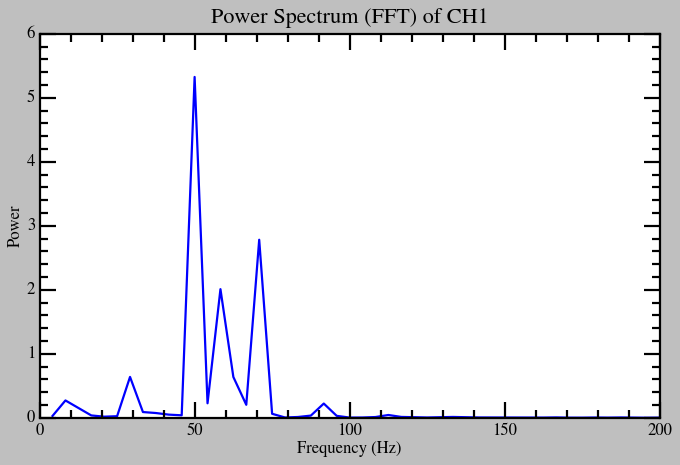

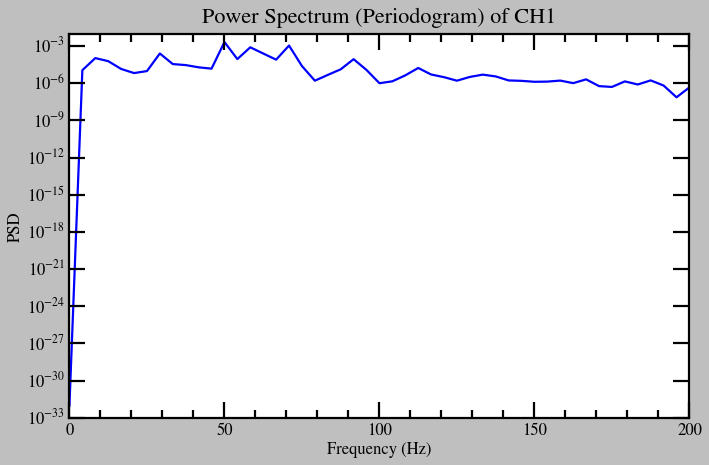

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import periodogram, find_peaks

# 1. Read the first two header lines to get Start and Increment
with open('data/NewFile1.csv', 'r') as f:
    header1 = f.readline().strip().split(',')
    header2 = f.readline().strip().split(',')
start = float(header2[3])
increment = float(header2[4])

# 2. Load the data (skip the header lines)
# Here we assume that after the header lines the data has 3 columns: Sequence, CH1, CH2.
df = pd.read_csv('data/Newfile1.csv', skiprows=2, header=None,
                 names=['Sequence', 'CH1', 'CH2'],
                 usecols=[0, 1, 2])

# 3. Compute the time axis using the provided Start and Increment
df['time'] = start + df['Sequence'] * increment

# 4. Define the sampling frequency
fs = 1.0 / increment  # For example, 1/(2e-4) = 5000 Hz

# 5. Perform power spectrum analysis on CH1

# Option A: Using FFT
y = df['CH1'].values
N = len(y)
Y = np.fft.fft(y)
freq = np.fft.fftfreq(N, d=1/fs)
power = np.abs(Y)**2 / N

# Plot only the positive frequencies
mask = freq > 0
plt.figure(figsize=(10, 6))
plt.plot(freq[mask], power[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')
plt.title('Power Spectrum (FFT) of CH1')
plt.xlim(0,200)
plt.show()

# Option B: Using a periodogram (which computes the power spectral density)
f, Pxx = periodogram(y, fs)
plt.figure(figsize=(10, 6))
plt.semilogy(f, Pxx)
plt.xlabel('Frequency (Hz)')
plt.ylabel('PSD')
plt.title('Power Spectrum (Periodogram) of CH1')
plt.xlim(0,200)
plt.show()

# Find the Maxima and Minima

Primary CH2 values at CH1 maxima:
99      0.0
180     6.0
291     5.0
372    -1.2
510    -7.6
595    -0.8
674     5.6
786     5.8
873    -1.6
1011   -7.0
1096   -0.6
Name: CH2, dtype: float64


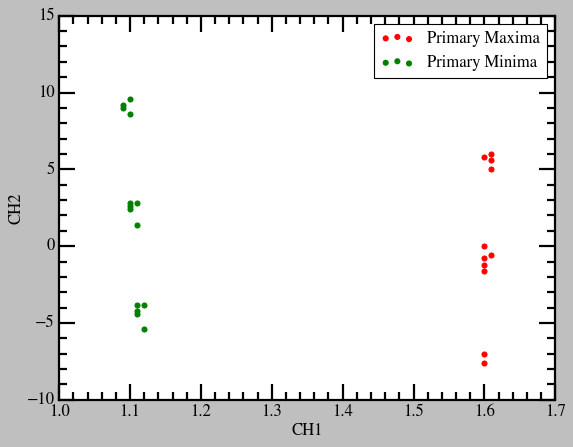

Primary CH2 values at CH1 minima:
51     -3.8
135     2.8
216     9.2
244     9.0
329     2.4
421    -5.4
551    -3.8
636     2.6
721     9.6
745     8.6
835     1.4
916    -4.4
1053   -4.2
1138    2.8
Name: CH2, dtype: float64


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# 1. Read the first two header lines to get Start and Increment
with open('data/NewFile1.csv', 'r') as f:
    header1 = f.readline().strip().split(',')
    header2 = f.readline().strip().split(',')
start = float(header2[3])
increment = float(header2[4])

# 2. Load the data (skip the header lines)
# Here we assume that after the header lines the data has 3 columns: Sequence, CH1, CH2.
df = pd.read_csv('data/Newfile1.csv', skiprows=2, header=None,
                 names=['Sequence', 'CH1', 'CH2'],
                 usecols=[0, 1, 2])

# 3. Compute the time axis using the provided Start and Increment
df['time'] = start + df['Sequence'] * increment

# --- Step 3: Extract CH2 Values at Local Minima and Maxima of CH1 ---

# Adjust these parameters based on your data:
prominence_threshold = 0.4  # set a threshold appropriate to your signal
min_distance = 10           # minimum number of samples between primary peaks

# For primary maxima in CH1:
primary_max_indices, max_properties = find_peaks(df['CH1'], prominence=prominence_threshold, distance=min_distance)

# For primary minima in CH1, we invert the signal:
primary_min_indices, min_properties = find_peaks(-df['CH1'], prominence=prominence_threshold, distance=min_distance)

# Extract corresponding CH2 values:
primary_ch2_at_max = df.loc[primary_max_indices, 'CH2']/10
primary_ch2_at_min = df.loc[primary_min_indices, 'CH2']/10

print("Primary CH2 values at CH1 maxima:")
print(primary_ch2_at_max)
plt.scatter(df.loc[primary_max_indices, 'CH1'], primary_ch2_at_max, color='red', label='Primary Maxima')
plt.scatter(df.loc[primary_min_indices, 'CH1'], primary_ch2_at_min, color='green', label='Primary Minima')
plt.xlabel('CH1')
plt.ylabel('CH2')
plt.legend()
plt.show()

print("Primary CH2 values at CH1 minima:")
print(primary_ch2_at_min)

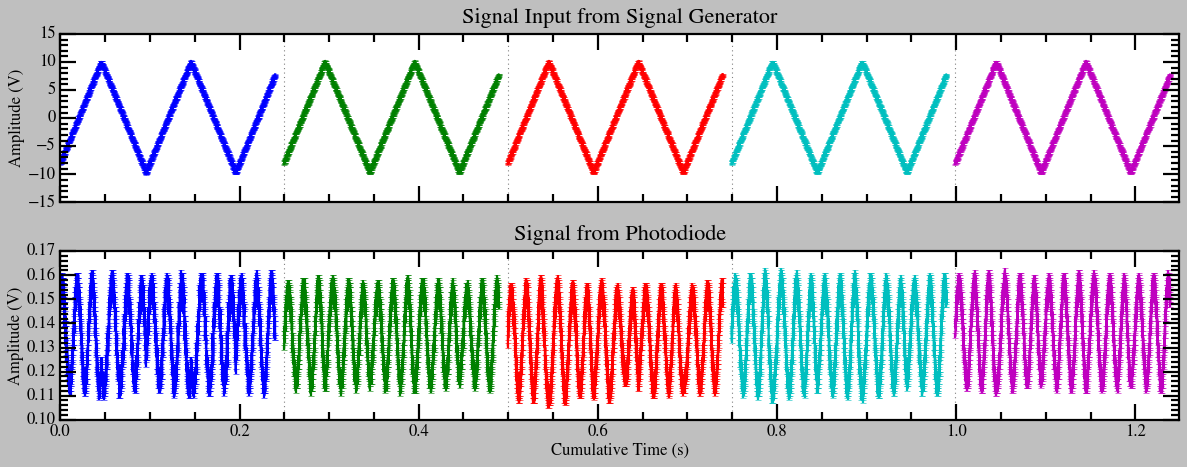

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of file names (adjust the paths as needed)
file_list = [
    'data/NewFile1.csv',
    'data/NewFile2.csv',
    'data/NewFile3.csv',
    'data/NewFile4.csv',
    'data/NewFile5.csv'
]

# Define a constant error value for both channels
error_value_ch2 = 0.1
error_value_ch1 = 0.001

# Initialize the cumulative time offset
cumulative_offset = 0

# Create two subplots: one for CH1 and one for CH2 (sharing the x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))

# Loop through each file to load, adjust the time, and plot the data
for i, file in enumerate(file_list):
    # --- Read the file and extract sampling parameters ---
    with open(file, 'r') as f:
        header1 = f.readline().strip().split(',')
        header2 = f.readline().strip().split(',')
    start = float(header2[3])
    increment = float(header2[4])
    
    # --- Load the data ---
    # Assumes that after the header lines, the CSV has 3 columns: Sequence, CH1, CH2.
    df = pd.read_csv(file, skiprows=2, header=None,
                     names=['Sequence', 'CH1', 'CH2'],
                     usecols=[0, 1, 2])
    
    # Compute the local time axis for the file: t = start + Sequence * increment.
    df['time_local'] = start + df['Sequence'] * increment
    # Reset time for this file so that it starts at 0
    df['time_local'] = df['time_local'] - df['time_local'].iloc[0]
    # Create a continuous (cumulative) time axis by adding the offset from previous files.
    df['time_cum'] = df['time_local'] + cumulative_offset

    # Plot CH1 with error bars on the top subplot
    ax2.errorbar(df['time_cum'], df['CH1']/10, yerr=error_value_ch1, fmt='-', 
                 capsize=3, label=f'CH1 from {file}')
    # Plot CH2 with error bars on the bottom subplot
    ax1.errorbar(df['time_cum'], df['CH2']/10, yerr=error_value_ch2, fmt='-', 
                 capsize=3, label=f'CH2 from {file}')

    # Update the cumulative offset: add a small gap for visual separation.
    new_offset = df['time_cum'].iloc[-1] + 0.01
    # Draw a vertical dotted line at the new offset on both subplots (except after the last file)
    if i < len(file_list) - 1:
        ax1.axvline(x=new_offset, color='gray', linestyle=':', linewidth=1)
        ax2.axvline(x=new_offset, color='gray', linestyle=':', linewidth=1)
    cumulative_offset = new_offset

# Set axis labels and titles
ax1.set_ylabel('Amplitude (V)')
ax2.set_ylabel('Amplitude (V)')
ax2.set_xlabel('Cumulative Time (s)')
ax1.set_title('Signal Input from Signal Generator')
ax2.set_title('Signal from Photodiode')
ax1.set_xlim(0, cumulative_offset)
ax2.set_xlim(0, cumulative_offset)
# fig.suptitle('Signal Input from Signal Generator', fontsize=14)

# Optionally, add legends (or comment these lines out to reduce clutter)
# ax1.legend(fontsize='small', loc='best')
# ax2.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.savefig('continuous_combined_data_subplots.png', dpi=300)
plt.show()

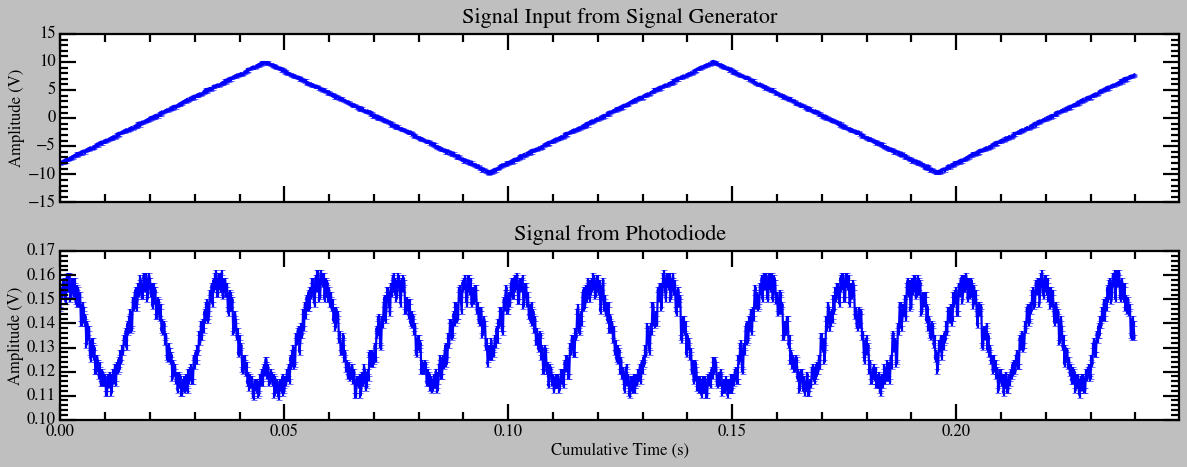

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# List of file names (adjust the paths as needed)
file_list = [
    'data/NewFile1.csv'
]

# Define a constant error value for both channels
error_value_ch2 = 0.1
error_value_ch1 = 0.001

# Initialize the cumulative time offset
cumulative_offset = 0

# Create two subplots: one for CH1 and one for CH2 (sharing the x-axis)
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(15, 6))

# Loop through each file to load, adjust the time, and plot the data
for i, file in enumerate(file_list):
    # --- Read the file and extract sampling parameters ---
    with open(file, 'r') as f:
        header1 = f.readline().strip().split(',')
        header2 = f.readline().strip().split(',')
    start = float(header2[3])
    increment = float(header2[4])
    
    # --- Load the data ---
    # Assumes that after the header lines, the CSV has 3 columns: Sequence, CH1, CH2.
    df = pd.read_csv(file, skiprows=2, header=None,
                     names=['Sequence', 'CH1', 'CH2'],
                     usecols=[0, 1, 2])
    
    # Compute the local time axis for the file: t = start + Sequence * increment.
    df['time_local'] = start + df['Sequence'] * increment
    # Reset time for this file so that it starts at 0
    df['time_local'] = df['time_local'] - df['time_local'].iloc[0]
    # Create a continuous (cumulative) time axis by adding the offset from previous files.
    df['time_cum'] = df['time_local'] + cumulative_offset

    # Plot CH1 with error bars on the top subplot
    ax2.errorbar(df['time_cum'], df['CH1']/10, yerr=error_value_ch1, fmt='-', 
                 capsize=3, label=f'CH1 from {file}')
    # Plot CH2 with error bars on the bottom subplot
    ax1.errorbar(df['time_cum'], df['CH2']/10, yerr=error_value_ch2, fmt='-', 
                 capsize=3, label=f'CH2 from {file}')

    # Update the cumulative offset: add a small gap for visual separation.
    new_offset = df['time_cum'].iloc[-1] + 0.01
    # Draw a vertical dotted line at the new offset on both subplots (except after the last file)
    if i < len(file_list) - 1:
        ax1.axvline(x=new_offset, color='gray', linestyle=':', linewidth=1)
        ax2.axvline(x=new_offset, color='gray', linestyle=':', linewidth=1)
    cumulative_offset = new_offset

# Set axis labels and titles
ax1.set_ylabel('Amplitude (V)')
ax2.set_ylabel('Amplitude (V)')
ax2.set_xlabel('Cumulative Time (s)')
ax1.set_title('Signal Input from Signal Generator')
ax2.set_title('Signal from Photodiode')
ax1.set_xlim(0, cumulative_offset)
ax2.set_xlim(0, cumulative_offset)
# fig.suptitle('Signal Input from Signal Generator', fontsize=14)

# Optionally, add legends (or comment these lines out to reduce clutter)
# ax1.legend(fontsize='small', loc='best')
# ax2.legend(fontsize='small', loc='best')

plt.tight_layout()
plt.savefig('single_raw_data.png', dpi=300)
plt.show()

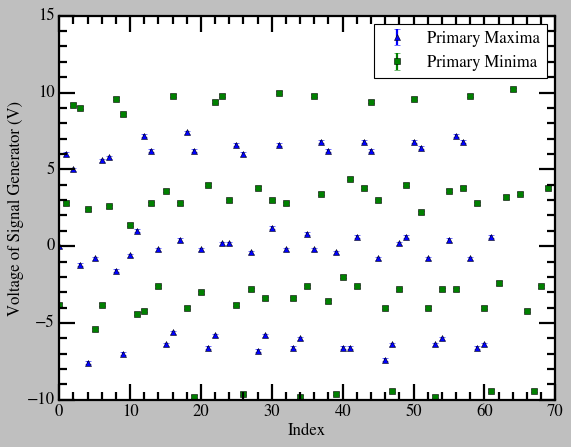

All CH2 values at CH1 maxima:
[ 0.   6.   5.  -1.2 -7.6 -0.8  5.6  5.8 -1.6 -7.  -0.6  1.   7.2  6.2
 -0.2 -6.4 -5.6  0.4  7.4  6.2 -0.2 -6.6 -5.8  0.2  0.2  6.6  6.  -0.4
 -6.8 -5.8  1.2  6.6 -0.2 -6.6 -6.   0.8 -0.2  6.8  6.2 -0.4 -6.6 -6.6
  0.6  6.8  6.2 -0.8 -7.4 -6.4  0.2  0.6  6.8  6.4 -0.8 -6.4 -6.   0.4
  7.2  6.8 -0.8 -6.6 -6.4  0.6]
All CH2 values at CH1 minima:
[-3.8  2.8  9.2  9.   2.4 -5.4 -3.8  2.6  9.6  8.6  1.4 -4.4 -4.2  2.8
 -2.6  3.6  9.8  2.8 -4.  -9.8 -3.   4.   9.4  9.8  3.  -3.8 -9.6 -2.8
  3.8 -3.4  3.  10.   2.8 -3.4 -9.8 -2.6  9.8  3.4 -3.6 -9.6 -2.   4.4
 -2.6  3.8  9.4  3.  -4.  -9.4 -2.8  4.   9.6  2.2 -4.  -9.8 -2.8  3.6
 -2.8  3.8  9.8  2.8 -4.  -9.4 -2.4  3.2 10.2  3.4 -4.2 -9.4 -2.6  3.8]


In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# List of file names (adjust the paths as needed)
file_list = [
    'data/NewFile1.csv',
    'data/NewFile2.csv',
    'data/NewFile3.csv',
    'data/NewFile4.csv',
    'data/NewFile5.csv'
]

# Define peak-detection parameters.
prominence_threshold = 0.4  # Adjust based on your signal
min_distance = 10           # Minimum number of samples between primary peaks

# Lists to store all CH2 values corresponding to primary peaks.
all_maxima = []
all_minima = []

for file in file_list:
    # --- Read the file and extract sampling parameters ---
    with open(file, 'r') as f:
        header1 = f.readline().strip().split(',')
        header2 = f.readline().strip().split(',')
    start = float(header2[3])
    increment = float(header2[4])
    
    # --- Load the data ---
    # Assumes that after the header lines, the CSV has 3 columns: Sequence, CH1, CH2.
    df = pd.read_csv(file, skiprows=2, header=None,
                     names=['Sequence', 'CH1', 'CH2'],
                     usecols=[0, 1, 2])
    
    # Compute the time axis
    df['time'] = start + df['Sequence'] * increment

    # --- Extract primary peaks from CH1 ---
    # Find primary maxima in CH1
    primary_max_indices, _ = find_peaks(df['CH1'], prominence=prominence_threshold, distance=min_distance)
    # Find primary minima in CH1 by inverting the signal
    primary_min_indices, _ = find_peaks(-df['CH1'], prominence=prominence_threshold, distance=min_distance)

    # --- Append the corresponding CH2 values to the overall lists ---
    all_maxima.extend(df.loc[primary_max_indices, 'CH2'].tolist())
    all_minima.extend(df.loc[primary_min_indices, 'CH2'].tolist())

# Scale the voltage values (for example, dividing by 10)
all_maxima = np.array(all_maxima) / 10
all_minima = np.array(all_minima) / 10

# Define a constant error value for the voltage (in Volts)
voltage_error = 0.1

# Plot with error bars using plt.errorbar
plt.figure()
plt.errorbar(np.arange(len(all_maxima)), all_maxima, yerr=voltage_error, fmt='^', 
             label='Primary Maxima', capsize=3)
plt.errorbar(np.arange(len(all_minima)), all_minima, yerr=voltage_error, fmt='s', 
             label='Primary Minima', capsize=3)
plt.xlabel('Index')
plt.ylabel('Voltage of Signal Generator (V)')
plt.legend()
plt.savefig('Primary_Maxima_Minima.png', dpi=300, bbox_inches='tight')
plt.show()

print("All CH2 values at CH1 maxima:")
print(all_maxima)
print("All CH2 values at CH1 minima:")
print(all_minima)

np.savetxt('Primary_Maxima.csv', all_maxima)
np.savetxt('Primary_Minima.csv', all_minima)

In [52]:
import numpy as np
from sklearn.cluster import KMeans

# Assume all_maxima is a 1D numpy array containing your scaled CH2 values for the primary maxima.
# For example:
# all_maxima = np.array([...])  # your CH2 data from the maxima, already scaled

# Reshape the data to be 2D (required for KMeans)
data_max = all_maxima.reshape(-1, 1)

# Use k-means clustering to group the data into 3 clusters.
kmeans_max = KMeans(n_clusters=3, random_state=50)
labels_max = kmeans_max.fit_predict(data_max)

# Optionally, sort the clusters by their centers for clarity:
cluster_centers = kmeans_max.cluster_centers_.flatten()
sorted_order = np.argsort(cluster_centers)
# Create a mapping from original label to sorted label.
sorted_labels_max = np.zeros_like(labels_max)
for new_label, orig_label in enumerate(sorted_order):
    sorted_labels_max[labels_max == orig_label] = new_label

# Now compute the average and standard deviation for each cluster:
print("Maxima:")
for cluster in range(3):
    cluster_data = data_max[sorted_labels_max == cluster].flatten()
    mean_val = np.mean(cluster_data)
    std_val = np.std(cluster_data)
    counting = (cluster_data.shape[0])
    error = std_val/np.sqrt(counting)
    print(f"Cluster {cluster}: Mean = {mean_val:.3f}, Std Dev = {std_val:.3f}, Error = {error:.3f}")

# Repeat the same for the minima:
data_min = all_minima.reshape(-1, 1)
kmeans_min = KMeans(n_clusters=4, random_state=42)
labels_min = kmeans_min.fit_predict(data_min)

# Sort the clusters by their centers:
cluster_centers_min = kmeans_min.cluster_centers_.flatten()
sorted_order_min = np.argsort(cluster_centers_min)
sorted_labels_min = np.zeros_like(labels_min)
for new_label, orig_label in enumerate(sorted_order_min):
    sorted_labels_min[labels_min == orig_label] = new_label

print("\nMinima:")
for cluster in range(4):
    cluster_data = data_min[sorted_labels_min == cluster].flatten()
    mean_val = np.mean(cluster_data)
    std_val = np.std(cluster_data)
    counting = cluster_data.shape[0]
    error = std_val/np.sqrt(counting)
    print(f"Cluster {cluster}: Mean = {mean_val:.3f}, Std Dev = {std_val:.3f}, Error = {error:.3f}")

Maxima:
Cluster 0: Mean = -6.478, Std Dev = 0.513, Error = 0.121
Cluster 1: Mean = -0.080, Std Dev = 0.688, Error = 0.138
Cluster 2: Mean = 6.411, Std Dev = 0.582, Error = 0.134

Minima:
Cluster 0: Mean = -9.600, Std Dev = 0.173, Error = 0.061
Cluster 1: Mean = -3.400, Std Dev = 0.784, Error = 0.157
Cluster 2: Mean = 3.183, Std Dev = 0.668, Error = 0.136
Cluster 3: Mean = 9.554, Std Dev = 0.416, Error = 0.115


In [53]:
import numpy as np

# Example values from clustering:
# 3 maxima (with means and standard deviations)
maxima_means = np.array([-6.478, -0.08, 0.688])
maxima_stds  = np.array([0.121, 0.138, 0.134])

# 4 minima (with means and standard deviations)
minima_means = np.array([-9.6, -3.4, 3.183, 9.554])
minima_stds  = np.array([0.061, 0.157, 0.136, 0.115])

# We assume that each maximum is between two minima:
# Pairing: max₁ between min₁ and min₂, max₂ between min₂ and min₃, and max₃ between min₃ and min₄.
pair_diffs = []
pair_uncerts = []

for i in range(len(maxima_means)):
    # Compute differences from the left and right minima:
    left_diff = maxima_means[i] - minima_means[i]         # should be positive if max > left min
    right_diff = minima_means[i+1] - maxima_means[i]        # should be positive if right min > max
    # The average "distance" for this peak:
    diff_i = (left_diff + right_diff) / 2.0
    
    # Uncertainty propagation for left and right differences:
    left_uncert = np.sqrt(maxima_stds[i]**2 + minima_stds[i]**2)
    right_uncert = np.sqrt(maxima_stds[i]**2 + minima_stds[i+1]**2)
    # The uncertainty on the average (assuming independent uncertainties)
    uncert_i = np.sqrt(left_uncert**2 + right_uncert**2) / 2.0
    
    pair_diffs.append(diff_i)
    pair_uncerts.append(uncert_i)

pair_diffs = np.array(pair_diffs)
pair_uncerts = np.array(pair_uncerts)

print("Pairwise average differences (peak-to-valley) and uncertainties:")
for i, (d, u) in enumerate(zip(pair_diffs, pair_uncerts)):
    print(f"Pair {i+1}: Difference = {d:.3f} ± {u:.3f}")

# Now compute the overall average distance.
# Here we simply take the mean of the three distances and calculate the standard error.
avg_diff = np.mean(pair_diffs)
std_error = np.std(pair_diffs, ddof=1) / np.sqrt(len(pair_diffs))

print("\nOverall average distance between minima and maxima:")
print(f"Average difference = {avg_diff:.3f} ± {std_error:.3f} (standard error)")

Pairwise average differences (peak-to-valley) and uncertainties:
Pair 1: Difference = 3.100 ± 0.120
Pair 2: Difference = 3.292 ± 0.143
Pair 3: Difference = 3.185 ± 0.130

Overall average distance between minima and maxima:
Average difference = 3.192 ± 0.055 (standard error)


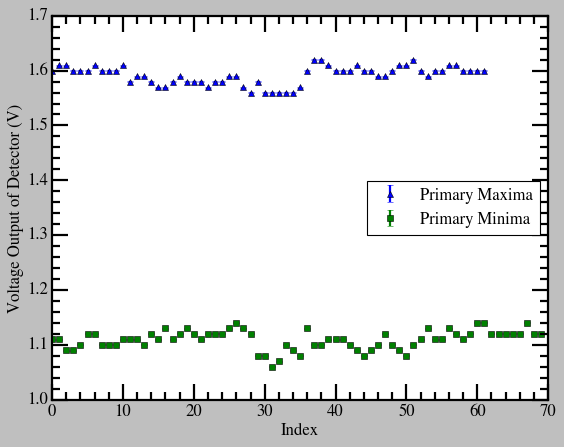

All CH1 values at maxima:
[1.6  1.61 1.61 1.6  1.6  1.6  1.61 1.6  1.6  1.6  1.61 1.58 1.59 1.59
 1.58 1.57 1.57 1.58 1.59 1.58 1.58 1.58 1.57 1.58 1.58 1.59 1.59 1.57
 1.56 1.58 1.56 1.56 1.56 1.56 1.56 1.57 1.6  1.62 1.62 1.61 1.6  1.6
 1.6  1.61 1.6  1.6  1.59 1.59 1.6  1.61 1.61 1.62 1.6  1.59 1.6  1.6
 1.61 1.61 1.6  1.6  1.6  1.6 ]
All CH1 values at minima:
[1.11 1.11 1.09 1.09 1.1  1.12 1.12 1.1  1.1  1.1  1.11 1.11 1.11 1.1
 1.12 1.11 1.13 1.11 1.12 1.13 1.12 1.11 1.12 1.12 1.12 1.13 1.14 1.13
 1.12 1.08 1.08 1.06 1.07 1.1  1.09 1.08 1.13 1.1  1.1  1.11 1.11 1.11
 1.1  1.09 1.08 1.09 1.1  1.12 1.1  1.09 1.08 1.1  1.11 1.13 1.11 1.11
 1.13 1.12 1.11 1.12 1.14 1.14 1.12 1.12 1.12 1.12 1.12 1.14 1.12 1.12]

Average Imax = 1.592 ± 0.002
Average Imin = 1.110 ± 0.002

Visibility = 0.179 ± 0.001


In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# List of file names (adjust the paths as needed)
file_list = [
    'data/NewFile1.csv',
    'data/NewFile2.csv',
    'data/NewFile3.csv',
    'data/NewFile4.csv',
    'data/NewFile5.csv'
]

# Define peak-detection parameters.
prominence_threshold = 0.4  # Adjust based on your signal
min_distance = 10           # Minimum number of samples between primary peaks

# Lists to store all CH1 values corresponding to primary peaks.
all_maxima = []
all_minima = []

for file in file_list:
    # --- Read the file and extract sampling parameters ---
    with open(file, 'r') as f:
        header1 = f.readline().strip().split(',')
        header2 = f.readline().strip().split(',')
    start = float(header2[3])
    increment = float(header2[4])
    
    # --- Load the data ---
    # Assumes that after the header lines, the CSV has 3 columns: Sequence, CH1, CH2.
    df = pd.read_csv(file, skiprows=2, header=None,
                     names=['Sequence', 'CH1', 'CH2'],
                     usecols=[0, 1, 2])
    
    # Compute the time axis
    df['time'] = start + df['Sequence'] * increment

    # --- Extract primary peaks from CH1 ---
    # Find primary maxima in CH1
    primary_max_indices, _ = find_peaks(df['CH1'], prominence=prominence_threshold, distance=min_distance)
    # Find primary minima in CH1 by inverting the signal
    primary_min_indices, _ = find_peaks(-df['CH1'], prominence=prominence_threshold, distance=min_distance)

    # --- Append the corresponding CH1 values to the overall lists ---
    all_maxima.extend(df.loc[primary_max_indices, 'CH1'].tolist())
    all_minima.extend(df.loc[primary_min_indices, 'CH1'].tolist())

# Convert lists to numpy arrays (no additional scaling is applied here)
all_maxima = np.array(all_maxima)
all_minima = np.array(all_minima)

# Define a constant error value for the measurements.
constant_error = 0.001

# Plot the extracted primary peaks with error bars.
plt.errorbar(np.arange(len(all_maxima)), all_maxima, yerr=constant_error, fmt='^', 
             label='Primary Maxima', capsize=3)
plt.errorbar(np.arange(len(all_minima)), all_minima, yerr=constant_error, fmt='s', 
             label='Primary Minima', capsize=3)
plt.xlabel('Index')
plt.ylabel('Voltage Output of Detector (V)')
plt.legend()
plt.savefig('Intensity.png', dpi=300, bbox_inches='tight')
plt.show()

print("All CH1 values at maxima:")
print(all_maxima)
print("All CH1 values at minima:")
print(all_minima)

# --- Calculate Visibility using CH1 Data ---
# Compute overall averages and uncertainties (standard error)
avg_Imax = np.mean(all_maxima)
std_err_Imax = np.std(all_maxima, ddof=1) / np.sqrt(len(all_maxima))

avg_Imin = np.mean(all_minima)
std_err_Imin = np.std(all_minima, ddof=1) / np.sqrt(len(all_minima))

print("\nAverage Imax = {:.3f} ± {:.3f}".format(avg_Imax, std_err_Imax))
print("Average Imin = {:.3f} ± {:.3f}".format(avg_Imin, std_err_Imin))

# Visibility is defined as: V = (Imax - Imin) / (Imax + Imin)
visibility = (avg_Imax - avg_Imin) / (avg_Imax + avg_Imin)

# Propagate the uncertainties using partial derivatives:
# dV/dImax = 2 * Imin / (Imax + Imin)^2 and dV/dImin = -2 * Imax / (Imax + Imin)^2
dV_dImax = 2 * avg_Imin / (avg_Imax + avg_Imin)**2
dV_dImin = -2 * avg_Imax / (avg_Imax + avg_Imin)**2

visibility_unc = np.sqrt((dV_dImax * std_err_Imax)**2 + (dV_dImin * std_err_Imin)**2)

print("\nVisibility = {:.3f} ± {:.3f}".format(visibility, visibility_unc))